In [1]:
import sys

import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

from multiview_mapping_toolkit.segmentation import SegmentorPhotogrammetryCameraSet
from multiview_mapping_toolkit.segmentation.derived_segmentors import LookUpSegmentor

from multiview_mapping_toolkit.utils.prediction_metrics import (
    compute_comprehensive_metrics,
)

sys.path.append("../..")
from constants_80m import get_IDs_to_labels, get_numpy_export_cf_filename

/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SITE_NAMES = ("chips", "delta", "lassic", "valley")

In [3]:
ortho_matrices = []
MVMT_matrices = []

ortho_metrics = []
MVMT_metrics = []

IDs_to_labels = get_IDs_to_labels()

class_names = list(IDs_to_labels.keys())
labels = list(IDs_to_labels.values())


for inference_site_name in SITE_NAMES:
    training_site_names = sorted(list(set(SITE_NAMES) - set([inference_site_name])))
    MVMT_matrices.append(
        np.load(
            get_numpy_export_cf_filename(
                inference_site_name, training_sites=training_site_names, is_ortho=False
            )
        )
    )
    ortho_matrices.append(
        np.load(
            get_numpy_export_cf_filename(
                inference_site_name, training_sites=training_site_names, is_ortho=True
            )
        )
    )

    if np.sum(MVMT_matrices[-1]) != np.sum(ortho_matrices[-1]):
        raise ValueError()

MVMT
ortho


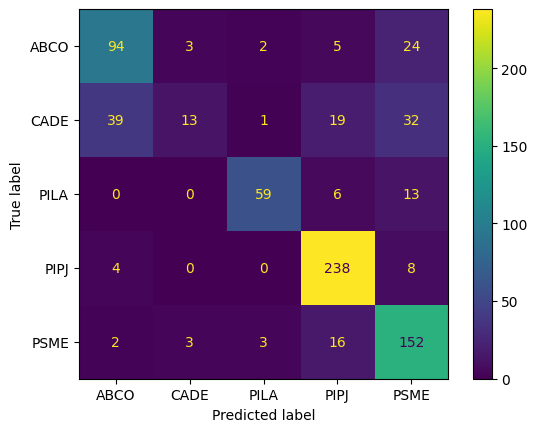

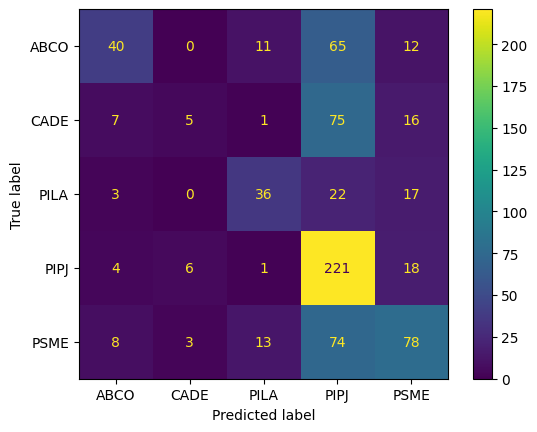

In [4]:
aggregated_ortho_cm = np.sum(ortho_matrices, axis=0)
aggregated_MVMT_cm = np.sum(MVMT_matrices, axis=0)
print("MVMT")
cf_disp = ConfusionMatrixDisplay(
    confusion_matrix=aggregated_MVMT_cm, display_labels=labels
)
cf_disp.plot()
print("ortho")
cf_disp = ConfusionMatrixDisplay(
    confusion_matrix=aggregated_ortho_cm, display_labels=labels
)
cf_disp.plot()

In [5]:
aggregated_ortho_metrics = compute_comprehensive_metrics(
    aggregated_ortho_cm, class_names=class_names
)
aggregated_multiview_metrics = compute_comprehensive_metrics(
    aggregated_MVMT_cm, class_names=class_names
)

site_accuracies = []
site_recalls = []
site_precisions = []


for ortho_cm, multiview_cm, site_name in zip(ortho_matrices, MVMT_matrices, SITE_NAMES):
    ortho_metrics = compute_comprehensive_metrics(ortho_cm, class_names=class_names)
    multiview_metrics = compute_comprehensive_metrics(
        multiview_cm, class_names=class_names
    )
    site_accuracies.extend([ortho_metrics["accuracy"], multiview_metrics["accuracy"]])
    site_recalls.extend(
        [
            ortho_metrics["class_averaged_recall"],
            multiview_metrics["class_averaged_recall"],
        ]
    )
    site_precisions.extend(
        [
            ortho_metrics["class_averaged_precision"],
            multiview_metrics["class_averaged_precision"],
        ]
    )


site_accuracies.extend(
    [aggregated_ortho_metrics["accuracy"], aggregated_multiview_metrics["accuracy"]]
)
site_recalls.extend(
    [
        aggregated_ortho_metrics["class_averaged_recall"],
        aggregated_multiview_metrics["class_averaged_recall"],
    ]
)
site_precisions.extend(
    [
        aggregated_ortho_metrics["class_averaged_precision"],
        aggregated_multiview_metrics["class_averaged_precision"],
    ]
)

site_accuracies =["Accuracy"] + [f"{x:.2f}" for x in site_accuracies]
site_recalls =   ["Recall (CA)"] + [f"{x:.2f}" for x in site_recalls]
site_precisions =["Precision (CA)"] + [f"{x:.2f}" for x in site_precisions]


print(" & ".join(site_accuracies) + "\\\\ \\hline")
print(" & ".join(site_recalls) + "\\\\ \\hline")
print(" & ".join(site_precisions) + "\\\\ \\hline")

Accuracy & 0.47 & 0.80 & 0.63 & 0.77 & 0.29 & 0.57 & 0.83 & 1.00 & 0.52 & 0.76\\ \hline
Recall (CA) & 0.34 & 0.70 & 0.49 & 0.63 & 0.53 & 0.79 & 0.85 & 1.00 & 0.43 & 0.69\\ \hline
Precision (CA) & 0.50 & 0.79 & 0.47 & 0.73 & 0.49 & 0.67 & 0.78 & 1.00 & 0.52 & 0.75\\ \hline


/ofo-share/repos-david/multiview-mapping-toolkit-stable/multiview_mapping_toolkit/utils/prediction_metrics.py:288: RuntimeWarning: invalid value encountered in scalar divide
  recall = true_positives / num_true
/ofo-share/repos-david/multiview-mapping-toolkit-stable/multiview_mapping_toolkit/utils/prediction_metrics.py:289: RuntimeWarning: invalid value encountered in scalar divide
  precision = true_positives / num_pred
